# Setup Environment

In [1]:
import numpy as np  # for array stuff and random
from PIL import Image  # for creating visual of our env
import cv2  # for showing our visual live
import matplotlib.pyplot as plt  # for graphing our mean rewards over time
import pickle  # to save/load Q-Tables
from matplotlib import style  # to make pretty charts because it matters.
import time  # using this to keep track of our saved Q-Tables.

In [109]:
SIZE = 10

HM_EPISODES = 1000000
MOVE_PENALTY = 1  # feel free to tinker with these!
ENEMY_PENALTY = 300  # feel free to tinker with these!
FOOD_REWARD = 3000  # feel free to tinker with these!
epsilon = 0.  # randomness
EPS_DECAY = 0.9999  # Every episode will be epsilon*EPS_DECAY
SHOW_EVERY = 1000  # how often to play through env visually.

start_q_table = None  # if we have a pickled Q table, we'll put the filename of it here.

LEARNING_RATE = 0.1
DISCOUNT = 0.95

PLAYER_N = 1  # player key in dict
FOOD_N = 2  # food key in dict
ENEMY_N = 3  # enemy key in dict

# the dict! Using just for colors
d = {1: (255, 175, 0),  # blueish color
     2: (0, 255, 0),  # green
     3: (0, 0, 255)}  # red

In [10]:
class Blob:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __str__(self):
        return f"{self.x}, {self.y}"
    def __sub__(self, other):
        return (self.x-other.x, self.y-other.y)
    def action(self, choice):
        '''
        Gives us 4 total movement options. (0, 1, 2, 3, 4, 5, 6, 7)
        '''
        if choice == 0:
            self.move(x=1, y=1)
        elif choice == 1:
            self.move(x=-1, y=-1)
        elif choice == 2:
            self.move(x=-1, y=1)
        elif choice == 3:
            self.move(x=1, y=-1)
        elif choice == 4:
            self.move(x=1, y=0)
        elif choice == 5:
            self.move(x=-1, y=0)
        elif choice == 6:
            self.move(x=0, y=1)
        elif choice == 7:
            self.move(x=0, y=-1)
            
    def move(self, x=False, y=False):

        # If no value for x, move randomly
        if not x:
            self.x += np.random.randint(-1, 2)
        else:
            self.x += x

        # If no value for y, move randomly
        if not y:
            self.y += np.random.randint(-1, 2)
        else:
            self.y += y


        # If we are out of bounds, fix!
        if self.x < 0:
            self.x = 0
        elif self.x > SIZE-1:
            self.x = SIZE-1
        if self.y < 0:
            self.y = 0
        elif self.y > SIZE-1:
            self.y = SIZE-1

In [4]:
if start_q_table is None:
    # initialize the q-table#
    # we are going to intilase
    # the q_table use as keys 
    # the states that going to 
    # the 2 distances 1 player-enemy 2 player-food
    #that is why we use range(-SIZE+1, SIZE) -- range(-9, 10)
    q_table = {}
    for i in range(-SIZE+1, SIZE):
        for ii in range(-SIZE+1, SIZE):
            for iii in range(-SIZE+1, SIZE):
                    for iiii in range(-SIZE+1, SIZE):
                        q_table[((i, ii), (iii, iiii))] = [np.random.uniform(-5, 0) for i in range(8)]
else:
    with open(start_q_table, "rb") as f:
        q_table = pickle.load(f)

In [11]:
def get_characters():
    p = (np.random.randint(0, SIZE), np.random.randint(0, SIZE))
    f = (np.random.randint(0, SIZE), np.random.randint(0, SIZE))
    e = (np.random.randint(0, SIZE), np.random.randint(0, SIZE))
    while(p == f or p == e or e == f):
            p = (np.random.randint(0, SIZE), np.random.randint(0, SIZE))
            f = (np.random.randint(0, SIZE), np.random.randint(0, SIZE))
            e = (np.random.randint(0, SIZE), np.random.randint(0, SIZE))
    player = Blob(p[0], p[1])
    food = Blob(f[0], f[1])
    enemy = Blob(e[0], e[1])
    return player, food, enemy

# Building and Training the Model

In [110]:
episode_rewards = []

for episode in range(HM_EPISODES):
    player, food, enemy = get_characters()
    if episode % SHOW_EVERY == 0:
        print(f"on #{episode}, epsilon is {epsilon}")
        print(f"{SHOW_EVERY} ep mean: {np.mean(episode_rewards[-SHOW_EVERY:])}")
        show = True
    else:
        show = False
    episode_reward = 0
    for i in range(10):
        obs = (player-food, player-enemy)
        #print(obs)
        if np.random.random() > epsilon:
            # GET THE ACTION
            action = np.argmax(q_table[obs])
        else:
            action = np.random.randint(0, 8)
        # Take the action!
        player.action(action)
        #### MAYBE ###
        #enemy.move()
        #food.move()
        ##############
        if player.x == enemy.x and player.y == enemy.y:
            reward = -ENEMY_PENALTY
        elif player.x == food.x and player.y == food.y:
            reward = FOOD_REWARD
        else:
            reward = -MOVE_PENALTY
        new_obs = (player-food, player-enemy)  # new observation
        max_future_q = np.max(q_table[new_obs])  # max Q value for this new obs
        current_q = q_table[obs][action]  # current Q for our chosen action
        if reward == FOOD_REWARD:
            new_q = FOOD_REWARD
        else:
            new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
        q_table[obs][action] = new_q
        if show:
            env = np.zeros((SIZE, SIZE, 3), dtype=np.uint8)  # starts an rbg of our size
            env[food.x][food.y] = d[FOOD_N]  # sets the food location tile to green color
            env[player.x][player.y] = d[PLAYER_N]  # sets the player tile to blue
            env[enemy.x][enemy.y] = d[ENEMY_N]  # sets the enemy location to red
            img = Image.fromarray(env, 'RGB')  # reading to rgb. Apparently. Even tho color definitions are bgr. ???
            img = img.resize((300, 300))  # resizing so we can see our agent in all its glory.
            cv2.imshow("image", np.array(img))  # show it!
            if reward == FOOD_REWARD or reward == -ENEMY_PENALTY:  # crummy code to hang at the end if we reach abrupt end for good reasons or not.
                if cv2.waitKey(500) & 0xFF == ord('q'):
                    break
            else:
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
            episode_reward += reward
            if reward == FOOD_REWARD or reward == -ENEMY_PENALTY:
                break

    #print(episode_reward)
    episode_rewards.append(episode_reward)
    epsilon *= EPS_DECAY

on #0, epsilon is 0.0
1000 ep mean: nan


C:\python\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\python\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


on #1000, epsilon is 0.0
1000 ep mean: 2.992
on #2000, epsilon is 0.0
1000 ep mean: 2.996
on #3000, epsilon is 0.0
1000 ep mean: -0.01
on #4000, epsilon is 0.0
1000 ep mean: -0.01
on #5000, epsilon is 0.0
1000 ep mean: 2.991
on #6000, epsilon is 0.0
1000 ep mean: 2.992
on #7000, epsilon is 0.0
1000 ep mean: 2.996
on #8000, epsilon is 0.0
1000 ep mean: 2.997
on #9000, epsilon is 0.0
1000 ep mean: 2.991
on #10000, epsilon is 0.0
1000 ep mean: 2.996
on #11000, epsilon is 0.0
1000 ep mean: 2.997
on #12000, epsilon is 0.0
1000 ep mean: 2.996
on #13000, epsilon is 0.0
1000 ep mean: 2.994
on #14000, epsilon is 0.0
1000 ep mean: 2.995
on #15000, epsilon is 0.0
1000 ep mean: 2.994
on #16000, epsilon is 0.0
1000 ep mean: 2.992
on #17000, epsilon is 0.0
1000 ep mean: -0.01
on #18000, epsilon is 0.0
1000 ep mean: 2.996
on #19000, epsilon is 0.0
1000 ep mean: 2.991
on #20000, epsilon is 0.0
1000 ep mean: -0.01
on #21000, epsilon is 0.0
1000 ep mean: 2.996
on #22000, epsilon is 0.0
1000 ep mean: 2.9

# Rewards Graph

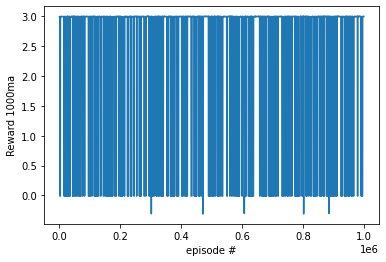

In [111]:
moving_avg = np.convolve(episode_rewards, np.ones((SHOW_EVERY,))/SHOW_EVERY, mode='valid')

plt.plot([i for i in range(len(moving_avg))], moving_avg)
plt.ylabel(f"Reward {SHOW_EVERY}ma")
plt.xlabel("episode #")
plt.show()

# Saving the Model

In [112]:
with open(f"qtable-v6.pickle", "wb") as f:
    pickle.dump(q_table, f)

# Loading and Testing the Model

In [148]:
start_q_table = "qtable-v5.pickle"
with open(start_q_table, "rb") as f:
        table_load = pickle.load(f)

In [114]:
def show(player, food, enemy, reward):
    env = np.zeros((SIZE, SIZE, 3), dtype=np.uint8)  # starts an rbg of our size
    env[food.x][food.y] = d[FOOD_N]  # sets the food location tile to green color
    env[player.x][player.y] = d[PLAYER_N]  # sets the player tile to blue
    env[enemy.x][enemy.y] = d[ENEMY_N]  # sets the enemy location to red
    img = Image.fromarray(env, 'RGB')  # reading to rgb. Apparently. Even tho color definitions are bgr. ???
    img = img.resize((300, 300))  # resizing so we can see our agent in all its glory.
    time.sleep(0.5)
    cv2.imshow("image", np.array(img))  # show it!
    

### Food and Enemy Fixed

In [194]:
player, food, enemy = get_characters()
for i in range(50):
        obs = (player-food, player-enemy)
        action = np.argmax(table_load[obs])
        # Take the action!
        player.action(action)
        ### MAYBE ###
        # enemy.move()
        # food.move()
        #############
        if player.x == enemy.x and player.y == enemy.y:
            reward = -ENEMY_PENALTY
        elif player.x == food.x and player.y == food.y:
            reward = FOOD_REWARD
        else:
            reward = -MOVE_PENALTY
        show(player, food, enemy, reward)
        if reward == FOOD_REWARD or reward == -ENEMY_PENALTY:  # crummy code to hang at the end if we reach abrupt end for good reasons or not.
            if cv2.waitKey(500) & 0xFF == ord('q'):
                break
        else:
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        if reward == FOOD_REWARD or reward == -ENEMY_PENALTY:
            break

### Food and Enemy Moving

In [189]:
player, food, enemy = get_characters()
for i in range(50):
        obs = (player-food, player-enemy)
        action = np.argmax(table_load[obs])
        # Take the action!
        player.action(action)
        ## MAYBE ###
        enemy.move()
        food.move()
        ############
        if player.x == enemy.x and player.y == enemy.y:
            reward = -ENEMY_PENALTY
        elif player.x == food.x and player.y == food.y:
            reward = FOOD_REWARD
        else:
            reward = -MOVE_PENALTY
        show(player, food, enemy, reward)
        if reward == FOOD_REWARD or reward == -ENEMY_PENALTY:  # crummy code to hang at the end if we reach abrupt end for good reasons or not.
            if cv2.waitKey(500) & 0xFF == ord('q'):
                break
        else:
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        if reward == FOOD_REWARD or reward == -ENEMY_PENALTY:
            break

In [195]:
cv2. destroyAllWindows()